The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==1.0.0-alpha0


# Bidirectional Recurrent Neural Networks
:label:`sec_bi_rnn`

In sequence learning,
so far we assumed that our goal is to model the next output given what we have seen so far, e.g., in the context of a time series or in the context of a language model. While this is a typical scenario, it is not the only one we might encounter. To illustrate the issue, consider the following three tasks of filling in the blank in a text sequence:

* I am `___`.
* I am `___` hungry.
* I am `___` hungry, and I can eat half a pig.

Depending on the amount of information available, we might fill in the blanks with very different words such as "happy", "not", and "very".
Clearly the end of the phrase (if available) conveys significant information about which word to pick.
A sequence model that is incapable of taking advantage of this will perform poorly on related tasks.
For instance, to do well in named entity recognition (e.g., to recognize whether "Green" refers to "Mr. Green" or to the color)
longer-range context is equally vital.
To get some inspiration for addressing the problem let's take a detour to probabilistic graphical models.


## Dynamic Programming in Hidden Markov Models

This subsection serves to illustrate the dynamic programming problem. The specific technical details do not matter for understanding the deep learning models
but they help in motivating why one might use deep learning and why one might pick specific architectures.

If we want to solve the problem using probabilistic graphical models we could for instance design a latent variable model as follows.
At any time step $t$,
we assume that there exists some latent variable $h_t$ that governs our observed emission $x_t$ via $P(x_t \mid h_t)$.
Moreover, any transition $h_t \to h_{t+1}$ is given by some state transition probability $P(h_{t+1} \mid h_{t})$. This probabilistic graphical model is then a *hidden Markov model*  as in :numref:`fig_hmm`.

![A hidden Markov model.](http://d2l.ai/_images/hmm.svg)
:label:`fig_hmm`

Thus,
for a sequence of $T$ observations we have the following joint probability distribution over the observed and hidden states:

$$P(x_1, \ldots, x_T, h_1, \ldots, h_T) = \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t), \text{ where } P(h_1 \mid h_0) = P(h_1).$$
:eqlabel:`eq_hmm_jointP`


Now assume that we observe all $x_i$ with the exception of some $x_j$ and it is our goal to compute $P(x_j \mid x_{-j})$, where $x_{-j} = (x_1, \ldots, x_{j-1}, x_{j+1}, \ldots, x_{T})$.
Since there is no latent variable
in $P(x_j \mid x_{-j})$,
we consider summing over
all the possible combinations of choices for $h_1, \ldots, h_T$.
In case any $h_i$ can take on $k$ distinct values (a finite number of states), this means that we need to sum over $k^T$ terms---usually mission impossible! Fortunately there is an elegant solution for this: *dynamic programming*.

To see how it works,
consider summing over latent variables
$h_1, \ldots, h_T$ in turn.
According to :eqref:`eq_hmm_jointP`,
this yields:

$$\begin{aligned}
    &P(x_1, \ldots, x_T) \\
    =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_2, \ldots, h_T} \underbrace{\left[\sum_{h_1} P(h_1) P(x_1 \mid h_1) P(h_2 \mid h_1)\right]}_{\pi_2(h_2) \stackrel{\mathrm{def}}{=}}
    P(x_2 \mid h_2) \prod_{t=3}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_3, \ldots, h_T} \underbrace{\left[\sum_{h_2} \pi_2(h_2) P(x_2 \mid h_2) P(h_3 \mid h_2)\right]}_{\pi_3(h_3)\stackrel{\mathrm{def}}{=}}
    P(x_3 \mid h_3) \prod_{t=4}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t)\\
    =& \dots \\
    =& \sum_{h_T} \pi_T(h_T) P(x_T \mid h_T).
\end{aligned}$$

In general we have the *forward recursion* as

$$\pi_{t+1}(h_{t+1}) = \sum_{h_t} \pi_t(h_t) P(x_t \mid h_t) P(h_{t+1} \mid h_t).$$

The recursion is initialized as $\pi_1(h_1) = P(h_1)$. In abstract terms this can be written as $\pi_{t+1} = f(\pi_t, x_t)$, where $f$ is some learnable function. This looks very much like the update equation in the latent variable models we discussed so far in the context of RNNs!

Entirely analogously to the forward recursion,
we can also
sum over the same set of latent variables with a backward recursion. This yields:

$$\begin{aligned}
    & P(x_1, \ldots, x_T) \\
     =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot P(h_T \mid h_{T-1}) P(x_T \mid h_T) \\
    =& \sum_{h_1, \ldots, h_{T-1}} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_T} P(h_T \mid h_{T-1}) P(x_T \mid h_T)\right]}_{\rho_{T-1}(h_{T-1})\stackrel{\mathrm{def}}{=}} \\
    =& \sum_{h_1, \ldots, h_{T-2}} \prod_{t=1}^{T-2} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_{T-1}} P(h_{T-1} \mid h_{T-2}) P(x_{T-1} \mid h_{T-1}) \rho_{T-1}(h_{T-1}) \right]}_{\rho_{T-2}(h_{T-2})\stackrel{\mathrm{def}}{=}} \\
    =& \ldots \\
    =& \sum_{h_1} P(h_1) P(x_1 \mid h_1)\rho_{1}(h_{1}).
\end{aligned}$$


We can thus write the *backward recursion* as

$$\rho_{t-1}(h_{t-1})= \sum_{h_{t}} P(h_{t} \mid h_{t-1}) P(x_{t} \mid h_{t}) \rho_{t}(h_{t}),$$

with initialization $\rho_T(h_T) = 1$.
Both the forward and backward recursions allow us to sum over $T$ latent variables in $\mathcal{O}(kT)$ (linear) time over all values of $(h_1, \ldots, h_T)$ rather than in exponential time.
This is one of the great benefits of the probabilistic inference with graphical models.
It is
also a very special instance of
a general message passing algorithm :cite:`Aji.McEliece.2000`.
Combining both forward and backward recursions, we are able to compute

$$P(x_j \mid x_{-j}) \propto \sum_{h_j} \pi_j(h_j) \rho_j(h_j) P(x_j \mid h_j).$$

Note that in abstract terms the backward recursion can be written as $\rho_{t-1} = g(\rho_t, x_t)$, where $g$ is a learnable function. Again, this looks very much like an update equation, just running backwards unlike what we have seen so far in RNNs. Indeed, hidden Markov models benefit from knowing future data when it is available. Signal processing scientists distinguish between the two cases of knowing and not knowing future observations as interpolation v.s. extrapolation.
See the introductory chapter of the book on sequential Monte Carlo algorithms for more details :cite:`Doucet.De-Freitas.Gordon.2001`.


## Bidirectional Model

If we want to have a mechanism in RNNs that offers comparable look-ahead ability as in hidden Markov models, we need to modify the RNN design that we have seen so far. Fortunately, this is easy conceptually. Instead of running an RNN only in the forward mode starting from the first token, we start another one from the last token running from back to front.
*Bidirectional RNNs* add a hidden layer that passes information in a backward direction to more flexibly process such information. :numref:`fig_birnn` illustrates the architecture of a bidirectional RNN with a single hidden layer.

![Architecture of a bidirectional RNN.](http://d2l.ai/_images/birnn.svg)
:label:`fig_birnn`

In fact, this is not too dissimilar to the forward and backward recursions in the dynamic programing of hidden Markov models.
The main distinction is that in the previous case these equations had a specific statistical meaning.
Now they are devoid of such easily accessible interpretations and we can just treat them as
generic and learnable functions.
This transition epitomizes many of the principles guiding the design of modern deep networks: first, use the type of functional dependencies of classical statistical models, and then parameterize them in a generic form.


### Definition

Bidirectional RNNs were introduced by :cite:`Schuster.Paliwal.1997`.
For a detailed discussion of the various architectures see also the paper :cite:`Graves.Schmidhuber.2005`.
Let's look at the specifics of such a network.


For any time step $t$,
given a minibatch input $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (number of examples: $n$, number of inputs in each example: $d$) and let the hidden layer activation function be $\phi$. In the bidirectional architecture, we assume that the forward and backward hidden states for this time step are $\overrightarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$ and $\overleftarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$, respectively,
where $h$ is the number of hidden units.
The forward and backward hidden state updates are as follows:


$$
\begin{aligned}
\overrightarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(f)} + \overrightarrow{\mathbf{H}}_{t-1} \mathbf{W}_{hh}^{(f)}  + \mathbf{b}_h^{(f)}),\\
\overleftarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(b)} + \overleftarrow{\mathbf{H}}_{t+1} \mathbf{W}_{hh}^{(b)}  + \mathbf{b}_h^{(b)}),
\end{aligned}
$$

where the weights $\mathbf{W}_{xh}^{(f)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(f)} \in \mathbb{R}^{h \times h}, \mathbf{W}_{xh}^{(b)} \in \mathbb{R}^{d \times h}, \text{ and } \mathbf{W}_{hh}^{(b)} \in \mathbb{R}^{h \times h}$, and biases $\mathbf{b}_h^{(f)} \in \mathbb{R}^{1 \times h} \text{ and } \mathbf{b}_h^{(b)} \in \mathbb{R}^{1 \times h}$ are all the model parameters.

Next, we concatenate the forward and backward hidden states $\overrightarrow{\mathbf{H}}_t$ and $\overleftarrow{\mathbf{H}}_t$
to obtain the hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times 2h}$ to be fed into the output layer.
In deep bidirectional RNNs with multiple hidden layers,
such information
is passed on as *input* to the next bidirectional layer. Last, the output layer computes the output $\mathbf{O}_t \in \mathbb{R}^{n \times q}$ (number of outputs: $q$):

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

Here, the weight matrix $\mathbf{W}_{hq} \in \mathbb{R}^{2h \times q}$ and the bias $\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ are the model parameters of the output layer. In fact, the two directions can have different numbers of hidden units.

### Computational Cost and Applications

One of the key features of a bidirectional RNN is that information from both ends of the sequence is used to estimate the output. That is, we use information from both future and past observations to predict the current one.
In the case of next token prediction this is not quite what we want.
After all, we do not have the luxury of knowing the next to next token when predicting the next one. Hence, if we were to use a bidirectional RNN naively we would not get a very good accuracy: during training we have past and future data to estimate the present. During test time we only have past data and thus poor accuracy. We will illustrate this in an experiment below.

To add insult to injury, bidirectional RNNs are also exceedingly slow.
The main reasons for this are that
the forward propagation
requires both forward and backward recursions
in bidirectional layers
and that the backpropagation is dependent on the outcomes of the forward propagation. Hence, gradients will have a very long dependency chain.

In practice bidirectional layers are used very sparingly and only for a narrow set of applications, such as filling in missing words, annotating tokens (e.g., for named entity recognition), and encoding sequences wholesale as a step in a sequence processing pipeline (e.g., for machine translation).
In :numref:`sec_bert` and :numref:`sec_sentiment_rnn`,
we will introduce how to use bidirectional RNNs
to encode text sequences.


In [1]:
from mxnet import np, npx
from mxnet.gluon import rnn
from d2l import mxnet as d2l

npx.set_np()

## (**Training a Bidirectional RNN for a Wrong Application**)

If we were to ignore all advice regarding the fact that bidirectional RNNs use past and future data and simply apply it to language models, we will get estimates with acceptable perplexity. Nonetheless, the ability of the model to predict future tokens is severely compromised as the experiment below illustrates. Despite reasonable perplexity, it only generates gibberish even after many iterations. We include the code below as a cautionary example against using them in the wrong context.


### Implementation from Scratch

To implement a bidirectional RNN from scratch, we can
include two unidirectional `RNNScratch` instances
with separate learnable parameters.


In [2]:
class BiRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.f_rnn = d2l.RNNScratch(num_inputs, num_hiddens, sigma)
        self.b_rnn = d2l.RNNScratch(num_inputs, num_hiddens, sigma)
        self.num_hiddens *= 2  # The output dimension will be doubled

States of forward and backward RNNs
are updated separately,
while outputs of these two RNNs are concatenated.


In [3]:
@d2l.add_to_class(BiRNNScratch)
def forward(self, inputs, Hs=None):
    f_H, b_H = Hs if Hs is not None else (None, None)
    f_outputs, f_H = self.f_rnn(inputs, f_H)
    b_outputs, b_H = self.b_rnn(reversed(inputs), b_H)
    outputs = [np.concatenate((f, b), -1) for f, b in zip(f_outputs, b_outputs)]
    return outputs, (f_H, b_H)

The training procedure is the same
as in :numref:`sec_rnn-scratch`.


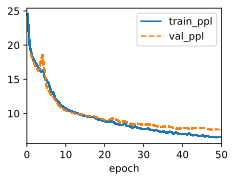

In [4]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
birnn = BiRNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(birnn, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

### Concise Implementation

Using the high-level APIs,
we can implement bidirectional RNNs more concisely.
Here we take a GRU model as an example.


In [5]:
class BiGRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = rnn.GRU(num_hiddens, bidirectional=True)
        self.num_hiddens *= 2

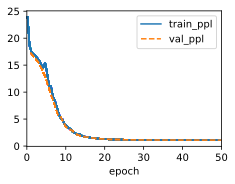

In [6]:
gru = BiGRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)

In [7]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it hasasasasasasasasasasas'

The output is clearly unsatisfactory for the reasons described above.
For a
discussion of more effective uses of bidirectional RNNs, please see the sentiment
analysis application
in :numref:`sec_sentiment_rnn`.

## Summary

* In bidirectional RNNs, the hidden state for each time step is simultaneously determined by the data prior to and after the current time step.
* Bidirectional RNNs bear a striking resemblance with the forward-backward algorithm in probabilistic graphical models.
* Bidirectional RNNs are mostly useful for sequence encoding and the estimation of observations given bidirectional context.
* Bidirectional RNNs are very costly to train due to long gradient chains.

## Exercises

1. If the different directions use a different number of hidden units, how will the shape of $\mathbf{H}_t$ change?
1. Design a bidirectional RNN with multiple hidden layers.
1. Polysemy is common in natural languages. For example, the word "bank" has different meanings in contexts “i went to the bank to deposit cash” and “i went to the bank to sit down”. How can we design a neural network model such that given a context sequence and a word, a vector representation of the word in the context will be returned? What type of neural architectures is preferred for handling polysemy?


[Discussions](https://discuss.d2l.ai/t/339)
